In [350]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from transformer_lens import HookedTransformer, utils
import circuitsvis as cv
from fancy_einsum import einsum
import transformer_lens.utils as utils
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from IPython.display import display
from model import create_model
from dataset import MinDataset

#### Initiliaze some functions to calculate the performance and get some visualization

In [351]:
def loss_fn(logits, y_batch, return_per_token=False):
    logits = logits[:, -1, :]
    log_probs = logits.log_softmax(-1)
    correct_log_probs = log_probs.gather(-1, y_batch).squeeze()

    if return_per_token:
        return -correct_log_probs
    return -correct_log_probs.mean()

def acc_fn(logits, y_batch, return_per_token=False):
    pred_logits = logits[:, -1, :]
    pred_tokens = torch.argmax(pred_logits, dim=1)
    accuracy = (pred_tokens == y_batch).float()

    if return_per_token:
        return accuracy
    return accuracy.mean().item()


def line(tensor, line_labels=None, yaxis="", xaxis="", **kwargs):
  if isinstance(tensor, torch.Tensor):
    tensor = tensor.detach().numpy()
  labels = {"y":yaxis, "x":xaxis}
  fig = px.line(tensor, labels=labels, **kwargs)
  if line_labels:
      for c, label in enumerate(line_labels):
          fig.data[c].name = label
  fig.show()

def line2(tensor1, tensor2=None, line_labels=None, yaxis="", xaxis="", colors=None, **kwargs):
    # Convert PyTorch tensors to numpy if necessary
    if isinstance(tensor1, torch.Tensor):
        tensor1 = tensor1.detach().numpy()
    if tensor2 is not None and isinstance(tensor2, torch.Tensor):
        tensor2 = tensor2.detach().numpy()

    labels = {"y": yaxis, "x": xaxis}
    
    # Initialize the figure as a blank figure using go.Figure
    fig = go.Figure()

    # Add the first dataset (tensor1) to the plot
    fig.add_trace(go.Scatter(y=tensor1, mode='lines', name=line_labels[0] if line_labels else "Line 1",
                             line=dict(color=colors[0] if colors else None)))

    # If the second dataset (tensor2) is provided, add it to the same plot
    if tensor2 is not None:
        fig.add_trace(go.Scatter(y=tensor2, mode='lines', name=line_labels[1] if line_labels else "Line 2",
                                 line=dict(color=colors[1] if colors else None)))

    # Update layout with axis labels
    fig.update_layout(
        xaxis_title=xaxis,
        yaxis_title=yaxis
    )

    # Show the plot
    fig.show()

### The Model

Our task is really basic and simple. We have a list of numbers and we want to predict the minimum of them. In this task I must say I was highly influenced by CallumMcDougall TakeMax problem and Neel Nanda's 200 problems in MI. 

For this task, I used a simple transformer model with only one layer and one head. This made the model very simple and easy to train. I hope that, due to the model's small size and simplicity, interpreting the model weights will be equally simple.

##### Upload the model

In [352]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)
filename = "models/min_model3.pt"

# # Check we can load in the model
model = create_model(
    max_num=50,
    seq_len=4,
    seed=23,
    d_model=24,
    d_head=24,
    n_layers=1,
    n_heads=1,
    normalization_type="LN",    
    d_mlp=None
)
model.load_state_dict(torch.load(filename))
cfg = model.cfg

cuda


C:\Users\i_kon\AppData\Local\Temp\ipykernel_8320\2443663711.py:17: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



#### a simple prediction function

In [353]:
def predict(toks, model, device='cuda',show_result=False,return_loss=False):
    if isinstance(toks, str):
        toks = toks.split(',')
        toks = [int(t) for t in toks]
        query_tensor = torch.tensor([toks], dtype=torch.long).to(device)
    else:
        query_tensor = toks

    model.eval()
    with torch.no_grad():
        output = model(query_tensor)
        predicted_token_idx = torch.argmax(output[:, -1, :], dim=-1)
        if return_loss or show_result:
            target_token_tensor = query_tensor.min(dim=1).values.unsqueeze(1)
            loss = loss_fn(output, target_token_tensor,return_per_token=True)
            if show_result:
                print(f"Predicted: {predicted_token_idx}")
                print(f"Target: {target_token_tensor.squeeze()}")
                print(f"Loss: {loss}")
            return predicted_token_idx, loss
    return predicted_token_idx

In [354]:
# predict("1,45,32,12,34,14,18",model,show_result=True)

dataset = MinDataset(size=15, max_num=cfg.d_vocab,length=cfg.n_ctx, seed=42).to(DEVICE)
_ = predict(dataset[:,:-1],model,show_result=True)

Predicted: tensor([14, 20,  0,  4,  6, 11, 13, 19, 14, 10, 19,  7,  9, 20,  8],
       device='cuda:0')
Target: tensor([14, 20,  0,  4,  6, 11, 13, 19, 14, 10, 19,  7,  9, 20,  8],
       device='cuda:0')
Loss: tensor([0.0009, 0.0010, 0.0005, 0.0006, 0.0005, 0.0006, 0.0007, 0.0008, 0.0009,
        0.0006, 0.0010, 0.0009, 0.0007, 0.0009, 0.0007], device='cuda:0')


#### some ablation code

In [355]:
from functools import partial

def predict_with_ablation(queries, model,device='cuda', mode="write", ablation_configs=None, return_loss=True):
    
    def ablation_hook_fn(activation, hook, head, positions):
        # Assuming activation shape: [batch_size, seq_len, num_heads, head_dim]
        if positions is None:
            # Ablate the entire head across all positions
            mean_values = activation[:, :, head, :].mean(dim=1, keepdim=True)
            activation[:, :, head, :] = mean_values.repeat(1, activation.size(1), 1)
        else:
            # Ablate only specified positions in the head
            for pos in positions:
                mean_values = activation[:, pos, head, :].mean(dim=0, keepdim=True)
                activation[:, pos, head, :] = mean_values.expand(activation.size(0), -1)
        return activation

    # Configure hooks for each specified ablation configuration
    model.reset_hooks()
    for config in ablation_configs:
        layer = config["layer"]
        head = config["head"]
        positions = config.get("positions", None)

        hook_name = utils.get_act_name("result", layer) if mode == "write" else utils.get_act_name("qkv", layer)

        # Define a closure to retain the current head and positions for each ablation config
        # def hook_closure(activation, hook, head=head, positions=positions):
        #     return ablation_hook_fn(activation, hook, head, positions)
        
        # model.add_hook(hook_name, hook_closure)
        hook_fn = partial(ablation_hook_fn, head=head, positions=positions)
        model.add_hook(hook_name, hook_fn)

    # Set up input data and parameters for inference
    cfg = model.cfg
    if return_loss:
        results, loss = predict(queries, model, device=device, return_loss=True)
    else:
        results = predict(queries, model, device=device, return_loss=False)
        loss = None
    return results, loss if return_loss else results

def extended_test_cases(queries, model, ablation_configs=None, print_results=True, show_loss_per_task=False):
    # Dictionary to store loss alert counts for each ablation configuration
    loss_alert_counts = {"total": 0, "alerts": 0}

    # If no ablation_configs are provided, default to all combinations of layers, heads, and positions
    if ablation_configs is None:
        ablation_configs = []
        for q in range(model.cfg.n_layers):  # Layer range
            for w in range(model.cfg.n_heads):  # Head range
                for e in range(model.cfg.n_ctx):  # Positions within the query
                    ablation_configs.append({"layer": q, "head": w, "positions": [e]})

    # Loop through each ablation configuration sequentially
    for config in ablation_configs:
        layer = config["layer"]
        head = config["head"]
        positions = config["positions"]

        # Run ablation inference for the current configuration
        results, loss = predict_with_ablation(queries, model, ablation_configs=[config], return_loss=True)
        # print(f"Ablation done on the model with config: {config}\n")
        
        # Process each query and categorize the results
        for i, (result, l) in enumerate(zip(results, loss)):
            if print_results:
                # Print individual query results
                print(f"Query {i+1} Generated response: {''.join(result)}, loss: {l}")
                print(f"Query {i+1}:     Real response: {queries[i][:-1].min(dim=1).values.item()} \n") 
            
            # Check for "LOSS" alert
            if l.item() > 0.7:
                if print_results:
                    print("LOSSS")
                loss_alert_counts["alerts"] += 1

            
            # Increment total
            loss_alert_counts["total"] += 1

        print("\n")
        print(f"Summary of Loss Alerts for config: {config}\n")
        total = loss_alert_counts["total"]
        alerts = loss_alert_counts["alerts"]
        print(f"Loss Alerts {alerts}/{total}")
        loss_alert_counts = {"total": 0, "alerts": 0}

def calculate_ablations_given_all_in_once(queries, model, ablation_configs, print_result=False):
    # Run ablation inference
    results, loss = predict_with_ablation(queries, model, ablation_configs=ablation_configs, return_loss=True)
    print("Ablation done on the model\n")
    
    # Dictionary to store loss alert counts
    loss_alert_counts = {"total": 0, "alerts": 0}
    
    # Print ablation configuration
    for ablation in ablation_configs:
        print(ablation)
    print("\n")

    # Process each query and categorize the results
    for i, (result, l) in enumerate(zip(results, loss)):
        if print_result:
            # Print individual query results
            print(f"Query {i+1} Generated response: {''.join(result)}, loss: {l}")
            print(f"Query {i+1}:     Real response: {queries[i][:-1].min(dim=1).values.item()} \n") 
        
        # Check for "LOSS" alert
        if l > 0.7:
            if print_result:
                print("LOSSS")
            loss_alert_counts["alerts"] += 1
        
        # Increment total
        loss_alert_counts["total"] += 1
                
    # Display summary of loss alerts
    print("\nSummary of Loss Alerts:\n")
    total = loss_alert_counts["total"]
    alerts = loss_alert_counts["alerts"]
    print(f"Loss Alerts {alerts}/{total}")

### Analyze

#### Analyze the models heads behavior and roles using head ablation

We already know that, typically, not all parts of a model are crucial. They may be useful in the early stages but not necessarily at the end. Therefore, we can remove some of them to gain a better understanding of the model.

To achieve this, we will ablate the model's heads and head positions one by one and observe how the model's performance changes.

Note: Normally, ablating all positions and heads one by one would be very expensive and time-consuming. However, since our model is very small and simple, we can afford to do this.

In [356]:
data = MinDataset(size=200, max_num=cfg.d_vocab,length=cfg.n_ctx, seed=42).to(DEVICE)
queries = data[:,:-1]

extended_test_cases(queries, model, print_results=False, show_loss_per_task=True)



Summary of Loss Alerts for config: {'layer': 0, 'head': 0, 'positions': [0]}

Loss Alerts 0/200


Summary of Loss Alerts for config: {'layer': 0, 'head': 0, 'positions': [1]}

Loss Alerts 0/200


Summary of Loss Alerts for config: {'layer': 0, 'head': 0, 'positions': [2]}

Loss Alerts 0/200


Summary of Loss Alerts for config: {'layer': 0, 'head': 0, 'positions': [3]}

Loss Alerts 197/200


It seems that only the last position is important for the model's output. This makes sense because we trained the model to predict the minimum at the last position. Therefore, the model should, at the very least, propagate the information about the minimum to the last position

In [357]:
data = MinDataset(size=200, max_num=cfg.d_vocab,length=cfg.n_ctx, seed=42).to(DEVICE).toks
queries = data[:,:-1]

ablation_configs = [
    {"layer": 0, "head": 0, "positions": [0]}, 
]
calculate_ablations_given_all_in_once(queries, model, ablation_configs,print_result=False)

Ablation done on the model

{'layer': 0, 'head': 0, 'positions': [0]}





Summary of Loss Alerts:

Loss Alerts 0/200


Using "mean" ablation, we ablated all the positions in our head except for the last position, and as you can see, the model's performance remains the same. This means that we can mostly focus on the last tokens position in order to interpret the model.

#### Analyze the attention patterns of the model


In [358]:
data = MinDataset(size=1, max_num=cfg.d_vocab,length=cfg.n_ctx, seed=23).to(DEVICE).toks
tokens = data[:,:-1]

result, loss = predict_with_ablation(tokens, model, ablation_configs=ablation_configs, return_loss=True)
print(f"Given List: {tokens[0].tolist()}")
print(f"Generated response: {result.item()}, loss: {loss}")
print(f"Real response: {tokens[0][:-1].min(dim=-1).values.item()}")

# Run the model with cache to get attention patterns
logits, cache = model.run_with_cache(tokens)

# Retrieve attention patterns for layers 0
attention_pattern = cache["pattern", 0, "attn"][0]  # Shape: [num_heads, seq_len, seq_len]

# Layer 0 attention visualization
print("LAYER 0")
attention_viz = cv.attention.attention_heads(tokens=[str(i.item()) for i in tokens[0]], attention=attention_pattern)

display(attention_viz)

Given List: [41, 46, 16, 47]
Generated response: 16, loss: 0.001005025114864111
Real response: 16
LAYER 0


#### Attention Pattern Analysis - Conclusion

The model's attention patterns are very simple. Almost for every position the model attends to tokens with lower values. This is exactly what we would expect from a model trained to predict the minimum value.

#### QK Circuit Analysis

In [359]:
import plotly.subplots as sp
import plotly.graph_objects as go
import numpy as np
from einops import rearrange
import math

def calculate_qk_attn_heatmap(model, only_posembed=False,keypos=-1, querypos=-1, tokens=None, layer=0):
    attn = model.blocks[layer].attn
    all_token_embeddings = model.embed(range(cfg.d_vocab))
    positional_embeddings = model.pos_embed(all_token_embeddings)
    
    token_embeddings_at_keypos = None
    token_embeddings_at_querypos = None
    
    if only_posembed:
        token_embeddings_at_keypos = positional_embeddings[0]
        token_embeddings_at_querypos = positional_embeddings[0]
    else:
        token_embeddings_at_keypos = (
            all_token_embeddings + positional_embeddings[:, keypos, :] if keypos > -1 else all_token_embeddings
        )
        token_embeddings_at_querypos = (
            all_token_embeddings + positional_embeddings[:, querypos, :] if querypos > -1 else all_token_embeddings
        )

    embeddings_key = einsum(
        "d_vocab d_model, n_heads d_model d_head -> n_heads d_vocab d_head",
        token_embeddings_at_keypos, attn.W_K
    )
    embeddings_query = einsum(
        "d_vocab d_model, n_heads d_model d_head -> n_heads d_vocab d_head",
        token_embeddings_at_querypos, attn.W_Q
    )

    # Calculate the QK attention heatmap across all heads
    qk_circuit_attn_heatmap = einsum(
        "n_heads d_vocab_q d_head, n_heads d_vocab_k d_head -> n_heads d_vocab_q d_vocab_k",
        embeddings_query, embeddings_key
    ).detach().cpu().numpy()

    return qk_circuit_attn_heatmap  # Shape: (n_heads, d_vocab_q, d_vocab_k)


def plot_qk_heatmap(model, layer=0, only_posembed=False, keypos=-1, querypos=-1, selected_heads=None):
    qk_attn_heatmap = calculate_qk_attn_heatmap(model, only_posembed=only_posembed, keypos=keypos, querypos=querypos, layer=layer)
    n_heads = qk_attn_heatmap.shape[0]

    # If selected_heads is None, plot all heads; otherwise, plot only selected heads
    heads_to_plot = selected_heads if selected_heads is not None else range(n_heads)
    
    # Set up the grid dimensions for subplots
    n_plots = len(heads_to_plot)
    n_cols = math.ceil(math.sqrt(n_plots))  # Arrange plots in a square grid
    n_rows = math.ceil(n_plots / n_cols)

    # Create subplots
    fig = sp.make_subplots(rows=n_rows, cols=n_cols, subplot_titles=[f"Head {head}" for head in heads_to_plot])
    x_labels = [str(i) for i in range(cfg.d_vocab)]
    y_labels = [str(i) for i in reversed(range(cfg.d_vocab))]

    for i, head in enumerate(heads_to_plot):
        row = i // n_cols + 1
        col = i % n_cols + 1 
        heatmap = go.Heatmap(
            z=qk_attn_heatmap[head][::-1],  # Reverse the y-axis data to display in increasing order from bottom to top
            colorscale="Hot",
            colorbar=dict(title="Attention Score") if i == 0 else None,  # Show color bar only for the first subplot
            x=x_labels,
            y=y_labels
        )
        
        fig.add_trace(heatmap, row=row, col=col)

    # Update layout to create square subplots for each head
    fig.update_layout(
        title="QK Circuit Attention Heatmaps for Selected Heads",
        height=600 * n_rows,
        width=600 * n_cols,
        showlegend=False
    )
    fig.show()

def plot_avg_qk_heatmap(model, keypositions, querypos=-1, layer=0, selected_heads=None):
    heatmaps = []
    
    for keypos in keypositions:
        heatmaps.append(calculate_qk_attn_heatmap(model, keypos=keypos, querypos=querypos, layer=layer))
    
    heatmaps = np.stack(heatmaps, axis=0)  # Shape: (len(keypositions), n_heads, d_vocab_q, d_vocab_k)

    # Average across both key positions and selected heads
    if selected_heads is not None:
        heatmaps = heatmaps[:, selected_heads, :, :]
    qk_circuit_attn_heatmap = np.mean(heatmaps, axis=(0, 1))

    fig = go.Figure(
        data=go.Heatmap(
            z=qk_circuit_attn_heatmap[::-1],  # Reverse the y-axis data to display in increasing order from bottom to top
            colorscale="Hot",
            colorbar=dict(title="Attention Score")
        )
    )

    fig.update_layout(
        title="Average QK Circuit Attention Heatmap Across Selected Heads",
        xaxis_title="Key Tokens",
        yaxis_title="Query Tokens",
        height=500,
        width=500,
    )
    fig.show()



In [360]:
layer = 0  # The layer you want to visualize
querypos = -1  # Position for the query embedding
keypos = -1  # Position for the key embedding
selected_heads = [0]  # Choose specific attention heads to visualize (e.g., head 0, head 1, head 3)


# Example 1: Plot QK heatmap for specific heads
plot_qk_heatmap(model, layer=layer, selected_heads=selected_heads, only_posembed=False, keypos=keypos, querypos=querypos)


In [366]:
layer = 0  # The layer you want to visualize
querypos = 3  # Position for the query embedding
keypos = -1  # Position for the key embedding
selected_heads = [0]  # Choose specific attention heads to visualize (e.g., head 0, head 1, head 3)


# Example 1: Plot QK heatmap for specific heads
plot_qk_heatmap(model, layer=layer, selected_heads=selected_heads, only_posembed=False, keypos=keypos, querypos=querypos)


#### QK Circuit Analysis - Conclusion 

A raw QK circuit using only token embeddings and no positional embeddings did not provide us with much information. However, when we incorporated positional embeddings, we observed that the model focuses more on numbers with lower values. Whatever the query token is, the model always attends to the key tokens with lower values. This is exactly what we would expect from a model trained to predict the minimum value.

#### OV Circuit Analysis

In [362]:
def plot_ov_heatmap_all_heads(model, layer=0, pos=-1):
    import torch
    import matplotlib.pyplot as plt
    from transformer_lens.utils import to_numpy
    import math

    attn = model.blocks[layer].attn

    # Get the vocabulary size and model dimensions
    d_vocab = model.cfg.d_vocab
    d_model = model.cfg.d_model
    n_heads = attn.W_V.shape[0]

    # Get the token embeddings for all tokens
    all_token_indices = torch.arange(d_vocab, device=model.cfg.device)
    all_token_embeddings = model.embed(all_token_indices)  # Shape: [d_vocab, d_model]

    # Optionally add positional embeddings
    if pos > -1:
        positional_embedding = model.pos_embed.W_pos[pos]  # Shape: [d_model]
        positional_embedding = positional_embedding.unsqueeze(0)  # Shape: [1, d_model]
        positional_embedding = positional_embedding.expand(d_vocab, d_model)  # Shape: [d_vocab, d_model]
        token_embeddings_at_pos = all_token_embeddings + positional_embedding  # Shape: [d_vocab, d_model]
    else:
        token_embeddings_at_pos = all_token_embeddings  # Shape: [d_vocab, d_model]

    # Compute the value embeddings using W_V
    W_V = attn.W_V  # Shape: [n_heads, d_model, d_head]
    embeddings_value = torch.einsum(
        "v d, n d h -> n v h",
        token_embeddings_at_pos,  # Shape: [d_vocab, d_model]
        W_V  # Shape: [n_heads, d_model, d_head]
    )  # Result: [n_heads, d_vocab, d_head]

    # Compute the output embeddings using W_O
    W_O = attn.W_O  # Shape: [n_heads, d_head, d_model]
    embeddings_out = torch.einsum(
        "n v h, n h d -> n v d",
        embeddings_value,  # Shape: [n_heads, d_vocab, d_model]
        W_O  # Shape: [n_heads, d_head, d_model]
    )  # Result: [n_heads, d_vocab, d_model]

    # Pass the output embeddings through the unembedding layer to get logits
    unembedding_matrix = model.unembed.W_U  # Shape: [d_model, d_vocab]
    ov_circuit_logits = torch.einsum(
        "n v d, d u -> n v u",
        embeddings_out,  # Shape: [n_heads, d_vocab, d_model]
        unembedding_matrix  # Shape: [d_model, d_vocab]
    )  # Result: [n_heads, d_vocab, d_vocab]

    n_cols = math.ceil(math.sqrt(n_heads))  # Arrange plots in a square grid
    n_rows = math.ceil(n_heads / n_cols)

    # Increase the figure size
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(10 * n_cols, 10 * n_rows))
    fig.suptitle(f'OV Circuit Heatmaps - Layer {layer}', fontsize=20)

    # Adjust subplot spacing
    fig.subplots_adjust(wspace=0.5, hspace=0.5)  # Increase spacing between subplots

    # Flatten the axes array for easy indexing
    print(axes)
    if n_rows == 1 and n_cols == 1:
        axes = [axes]
    else:
        axes = axes.flatten()
    

    # Display all indices on both axes
    x_labels = [str(i) for i in range(d_vocab)]
    y_labels = [str(i) for i in range(d_vocab)]

    # Plot each head
    for head in range(n_heads):
        logits = ov_circuit_logits[head]  # Shape: [d_vocab, d_vocab]
        ax = axes[head]
        im = ax.imshow(to_numpy(logits), cmap="hot", interpolation="nearest")
        ax.set_title(f'Head {head}', fontsize=14)
        ax.set_xticks(range(len(x_labels)))
        ax.set_xticklabels(x_labels, rotation=0, fontsize=8)
        ax.set_yticks(range(len(y_labels)))
        ax.set_yticklabels(y_labels, fontsize=8)
        
        # Add an individual colorbar for each subplot
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    # Hide any unused subplots
    for i in range(n_heads, len(axes)):
        axes[i].axis('off')

    plt.show()


Axes(0.125,0.11;0.775x0.77)


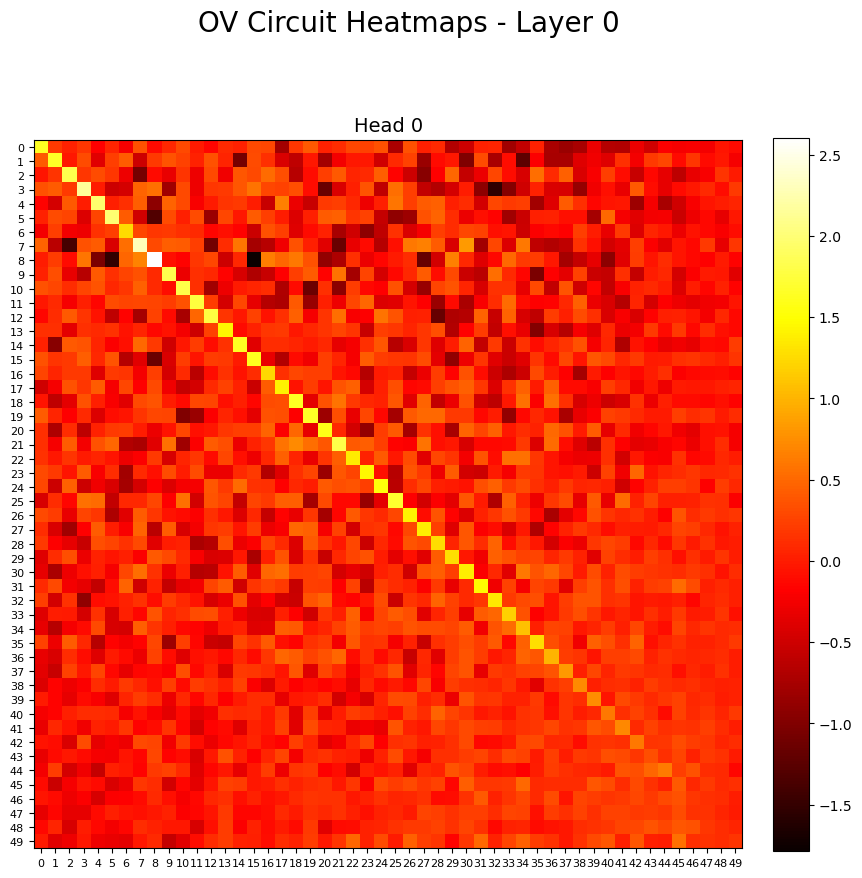

In [363]:
plot_ov_heatmap_all_heads(model, layer=0, pos=-1)


Axes(0.125,0.11;0.775x0.77)


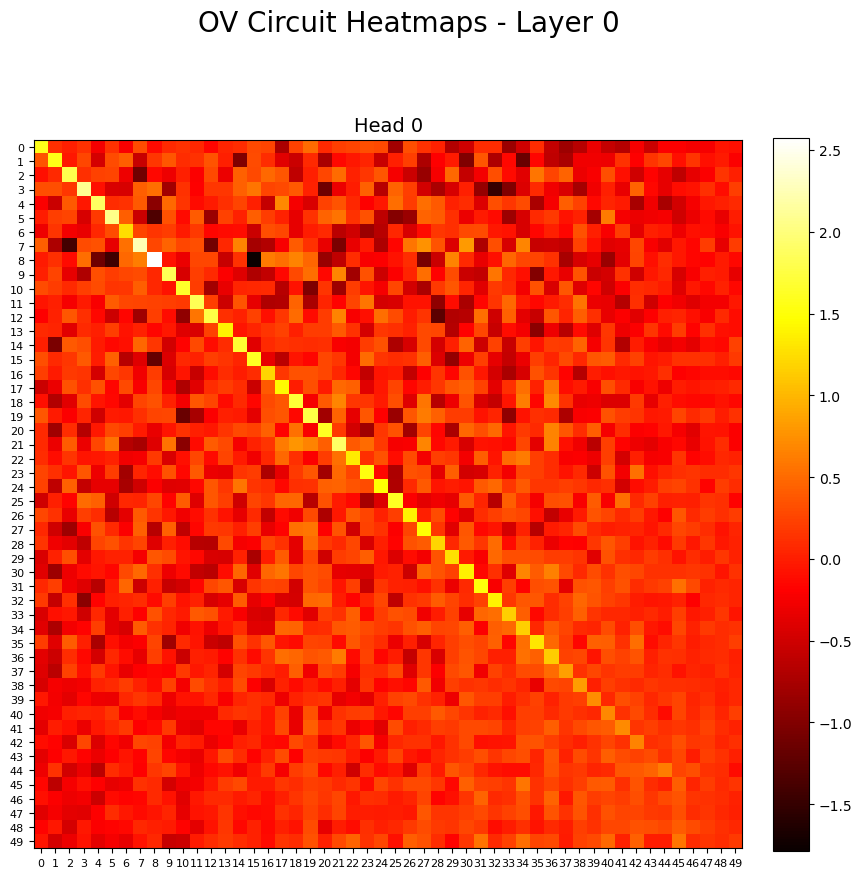

In [364]:
plot_ov_heatmap_all_heads(model, layer=0, pos=1)


#### OV Circuit Analysis and General Conclusion

At first glance, we can easily observe that the OV circuit exhibits strong diagonal patterns. In other words, every token maximizes its own logits, which can be seen as a form of copying.

If we take a step back to explain the general behavior of the model: the model uses the QK circuit to attend to tokens with lower values in almost every position. Once the QK circuit has attended to the token with the lower value, the OV circuit maximizes the logits of that token, resulting in the token with the minimum value being copied to the last position.

## Some advanced interpretations

#### The changes on OV Circuit with different model size and hyperparameters

After I saw that the OV circuit bottom right diaogonals pattern start to diminish I trained the model with different hyperparameters and model sizes. I observed that regardless the range of numbers in the list, as the models seq_len increases the OV circuit starts to lose its diagonal pattern. Firstly I want to show my observations than I will try to explain why this is happening.

You can check the `training_args.txt` file; all training details are there. Here I'll only show the hyperparameters that change:

##### Model1 - max_num=100, seq_len=2, trainset_size=60,000, valset_size=20,000
![Model 1](images/model1.png)

##### Model2 - max_num=50, seq_len=2, trainset_size=60,000, valset_size=20,000
![Model 2](images/model2.png)

From these observations above, we can see that although the max_num/range is higher in the second model, the OV circuit didn't change much.

Now let's see the changes when we increase the `seq_len`:

#### Model2 - max_num=50, seq_len=2, trainset_size=60,000, valset_size=20,000
![Model 2](images/model2.png)

#### Model3 - max_num=50, seq_len=4, trainset_size=60,000, valset_size=20,000
![Model 3](images/model3.png)

#### Model4 - max_num=50, seq_len=6, trainset_size=60,000, valset_size=20,000
![Model 4](images/model4.png)

#### Model5 - max_num=50, seq_len=10, trainset_size=60,000, valset_size=20,000
![Model 5](images/model5.png)

Here we can clearly see that as the `seq_len` increases, the OV circuit starts to lose its diagonal pattern towards the bottom-right corner, i.e., higher value tokens. My interpretation of this is:

Normally, intuitively, we would expect the model to attend and copy information with lower values. As expected, the diagonal is much brighter at the upper left corner. However, numbers close to the upper range could also be the minimum. For example, if the list is `[45, 48, 47]`, the minimum is `45`. But as the model's `seq_len` increases, the probability of the minimum value being at the end of the list decreases.

With basic mathematical intuition, we can explain this. If the dataset generator is producing numbers uniformly between 0-50:
- Numbers between 0-40 make up \( \frac{40}{50} \) of the range.
- Numbers between 40-50 make up \( \frac{10}{50} \) of the range.

For the smallest number to be in the range 40-50, **all** \( n \) numbers must be in that range. The probability of this happening is:

\[
P = \left(\frac{10}{50}\right)^n = \left(\frac{1}{5}\right)^n
\]

As \( n \) increases, this probability gets smaller because you're multiplying a small number (\( \frac{1}{5} \)) by itself many times. So, the more numbers you have, the less likely the smallest is between 40-50.

Another way to prove this is to increase the dataset size significantly. This problem will start to resolve, and the bottom-left will get brighter.

#### Model4 - max_num=50, seq_len=6, trainset_size=60,000, valset_size=20,000
![Model 4](images/model4.png)

#### Model6 - max_num=50, seq_len=6, trainset_size=600,000, valset_size=200,000
![Model 6](images/model6.png)
